## Import standard libraries

In [1]:
import torch
import torch.nn as nn  # we'll use this a lot going forward!
import torch.nn.functional as F

import numpy as np
import warnings

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import pyplot as plt, rc

# Import json library and create function to format dictionaries.
import json
format_json = lambda x: json.dumps(x, indent=4)

# Import pandas and set pandas DataFrame visualization parameters
from IPython.display import display
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Set rendering parameters to use TeX font if not working on Juno app.
from pathlib import Path
import os
if not '/private/var/' in os.getcwd():
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)
    
# Get current working directory path for the tool parent folder and print it.
parent_folder = 'Tool'
cwd = str(Path(os.getcwd()[:os.getcwd().index(parent_folder)+len(parent_folder)]))
print('Parent working directory: %s' % cwd)


Parent working directory: /Users/jjrr/Documents/SCA-Project/Tool


## Import user defined libraries

In [2]:
# Import custom libraries from local folder.
import sys
sys.path.append("..")

from calib import utils, eda, config, sdg
from calib import ann, rnn

## Data preparation

### Import training dataset

In [3]:
# Import transformed training dataset
df = eda.import_cdm_data(os.path.join(cwd,'data','esa-challenge',
                                      'train_data_transformed.csv'))

# Count number of CDMs available per event
nb_cdms = df.groupby(['event_id']).count()['time_to_tca'] \
            .to_numpy(dtype=np.int16)

# Define window size and number of events to forecast
min_cdms = 3

print(f'Events suitable for training (More than {min_cdms-1} CDMs): '
      f'{np.sum(nb_cdms>=min_cdms)}'
      f' ({np.sum(nb_cdms>=min_cdms)/len(nb_cdms)*100:5.1f}%)')
print(f'Time sequences with event_id integrity per feature: '
      f'{np.sum(nb_cdms[nb_cdms>=min_cdms]-min_cdms)}')

# Count number of CDMs per event
ts_events  = df[['event_id', 'time_to_tca']].groupby(['event_id']).count() \
                  .rename(columns={'time_to_tca':'nb_cdms'})

# Get events that have a minimum number of CDMs equal to the window_size + 
# events_to_forecast
events_filter = list(ts_events[ts_events['nb_cdms']>=min_cdms].index.values)

# Redefine DataFrame to contain only events suitable for TSF to save memory
df = df[df['event_id'].isin(events_filter)]

# Show first data points to explore data types
display(df.head(10))
df.info()

Events suitable for training (More than 2 CDMs): 11731 ( 89.2%)
Time sequences with event_id integrity per feature: 124820


,event_id,mission_id,risk,max_risk_estimate,max_risk_scaling,time_to_tca,miss_distance,c_object_type,geocentric_latitude,azimuth,elevation,mahalanobis_distance,F10,F3M,SSN,AP,time_to_cdm,cdms_to_tca,relative_speed,relative_velocity_r,relative_velocity_t,relative_velocity_n,relative_position_r,relative_position_t,relative_position_n,t_cd_area_over_mass,t_cr_area_over_mass,c_cd_area_over_mass,c_cr_area_over_mass,t_j2k_ecc,t_j2k_inc,t_j2k_sma,t_h_apo,t_h_per,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_h_apo,c_h_per,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_sedr,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_rcs_estimate,c_sedr,t_span,c_span,t_position_covariance_det,c_position_covariance_det
0,0,5,-10.204955,-7.834756,8.602101,0.223828,0.248717,UNKNOWN,-0.367870,-0.118094,0.001495,0.064715,0,0,0,0,0.179652,0.20,0.6896,-0.010286,-0.631850,-0.276295,0.113450,0.066407,-0.151853,0.345650,0.119550,0.017435,0.025321,0.003997,0.528489,0.804718,0.695229,0.635491,0.060567,0.003144,0.902096,0.017385,0.821994,-0.397969,0.292258,0.040799,0.394221,-0.999674,-0.038498,-0.981098,0.214612,-0.316493,-0.210247,0.170737,-0.001551,0.531593,0.002117,-0.179278,-0.824859,0.473976,-0.002576,0.825216,-0.999998,0.003565,-0.732954,0.220006,-0.814249,-0.220621,0.249855,0.196620,0.722186,-0.196908,-0.668487,0.087542,0.349138,0.307780,0.681469,0.036088,0.240117,-0.119684,0.254070,-0.343672,-0.112597,-0.363352,-0.059420,1.0,0.0,3.78,3.78,459,458,98.9,1.265,0.4020,-0.658611,180.0,2.0,15.85,15.85,15,15,100.0,2.360,NaN,-0.437818,1.0,2.0,0.225180,0.638829
1,0,5,-10.355758,-7.848937,8.956374,0.172499,0.242400,UNKNOWN,-0.367853,-0.118094,0.001454,0.135770,0,0,0,0,0.127650,0.15,0.6896,-0.010000,-0.631850,-0.276295,0.118575,0.064680,-0.147998,0.337175,0.152317,0.017435,0.025321,0.003996,0.528489,0.804722,0.695225,0.635500,0.060569,0.003144,0.902096,0.017386,0.822013,-0.073137,0.297366,0.060541,0.069652,-0.998192,-0.052511,-0.994240,-0.029644,-0.302333,0.034030,0.179696,0.001552,0.561142,-0.005165,-0.181036,-0.818207,0.482754,-0.003578,0.818573,-0.999998,0.004574,-0.728759,0.202595,-0.817490,-0.203216,0.258964,0.195718,0.721903,-0.196008,-0.674979,0.078774,0.348067,0.251663,0.681141,0.036770,0.240094,-0.176181,0.253741,-0.349081,-0.112847,-0.364476,-0.059431,1.0,0.0,3.79,3.79,456,455,98.5,1.270,0.4020,-0.648106,180.0,2.0,15.85,15.85,15,15,100.0,2.360,NaN,-0.437818,1.0,2.0,0.194086,0.638635
2,0,5,-10.345631,-7.847406,8.932195,0.136028,0.241250,UNKNOWN,-0.367850,-0.118094,0.001454,0.173950,0,0,0,0,0.186262,0.10,0.6896,-0.010000,-0.631850,-0.276295,0.118650,0.064402,-0.147290,0.333925,0.117617,0.017435,0.025321,0.003996,0.528489,0.804722,0.695229,0.635497,0.060570,0.003144,0.902096,0.017386,0.822018,-0.109230,0.305189,0.043711,0.107079,-0.996235,-0.034287,-0.996674,0.033933,-0.308501,-0.030161,0.123760,0.019630,0.579274,-0.023726,-0.125737,-0.817408,0.483828,-0.003742,0.817774,-0.999998,0.004738,-0.729083,0.201698,-0.817662,-0.202320,0.260092,0.195558,0.721854,-0.195849,-0.675347,0.075784,0.347942,0.226518,0.681078,0.037494,0.240090,-0.202350,0.253678,-0.352092,-0.112859,-0.363766,-0.059433,1.0,0.0,3.79,3.80,456,455,98.5,1.257,0.4020,-0.647529,180.0,2.0,15.85,15.85,15,15,100.0,2.360,NaN,-0.437818,1.0,2.0,0.179284,0.638599
3,0,5,-10.337809,-7.845880,8.913444,0.082810,0.242983,UNKNOWN,-0.367855,-0.118094,0.001454,0.217688,0,0,0,0,0.160932,0.05,0.6896

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160013 entries, 0 to 162633
Columns: 105 entries, event_id to c_position_covariance_det
dtypes: category(7), float64(90), int16(8)
memory usage: 115.4 MB


## Time-Series Forecasting problem

### Converting data from Pandas DataFrame to Time-Series Pytorch Tensors

In [4]:
# Get inputs and outputs in the right shape to feed the LSTM model
output_features = config.get_features(**{'continuous':True, 'variable': True, 
                                         'cluster':'relative_state'})
input_features  = output_features 

# Get input and output size from the list of features
input_size = len(input_features)
output_size = len(output_features)

print(f'Inputs ({input_size}): {input_features} '
      f'\nOutputs ({output_size}): {output_features} ')

Inputs (3): ['relative_position_r', 'relative_position_t', 'relative_position_n'] 
Outputs (3): ['relative_position_r', 'relative_position_t', 'relative_position_n'] 


In [5]:
# Get input variable features from config file.
features = input_features

# Check if file containing tensors is available in the data folder and load it
# tsf_tensors = torch.load(filepath) if os.path.exists(filepath) else {}
ff_tensors = {}

# Get time_to_tca data and convert it to tensor.
time_to_tca = df['time_to_tca'].to_numpy(dtype='float32')
time_to_tca = torch.nan_to_num(torch.FloatTensor(time_to_tca))

# Iterate over all features to get the time series subsets
pb_features = utils.progressbar(iterations = range(len(features)), 
                                desc_loc='right')

for f in pb_features.iterations:

    # Initialize list of tensors for feature f
    feature = features[f]
    
    # Get filename and filepath and check if it already exists
    filename = f'ts_ann_{feature}.pt'
    filepath = os.path.join(cwd,'data','tensors', filename)

    if os.path.exists(filepath):
        # If tensors already exists, load them.
        description = f'> Loading tensors from feature {feature} ...'
        pb_features.refresh(i = f+1, description = description)
        
        ff_tensors[feature] = torch.load(filepath)
    else:

        ff_tensors[feature] = []

        # Get feature data from dataset and convert it to a tensor.
        feature_dtype = str(df[feature].dtype).lower()
        data = df[feature].to_numpy(dtype=feature_dtype)
        data = torch.nan_to_num(torch.FloatTensor(data))

        for e, event_id in enumerate(events_filter):

            # Print progress bar
            subprogress = (e+1)/len(events_filter)*100
            description = f'> Extracting sequences of time-series ' + \
                          f'from feature {feature:<30s}  ' + \
                          f'(Progress: {subprogress:5.1f}%)'
            pb_features.refresh(i = f + 1, 
                                description = description, 
                                last_iteration = False)

            # Get full sequence from dataset and convert it to a tensor.
            event_filter = torch.BoolTensor(df['event_id']==event_id)

            # Add Time-Series subsets from full sequence tensor and add it to 
            # the list for the feature f

            ff_tensors[feature] = ff_tensors[feature] + \
                ann.event_ts_sets(torch.masked_select(data, event_filter), 
                                  torch.masked_select(time_to_tca, event_filter))

        # Save tensors containing all Time-Series subsets for training organised 
        # by feature.
        description = f'Saving tensors with sequences of time-series into ' + \
                      f'external file ...'
        # torch.save(tsf_tensors[feature], 
        #            os.path.join(cwd,'data','tensors', filename))
        pb_features.refresh(i = f + 1, description = description)


>  33% |███▍      | 1/3 | Remaining time: 00:00 (0.00 it/s) 
>  33% |███▍      | 1/3 | Remaining time: 00:00 (0.00 it/s) position_r             (Progress:   0.0%)
>  33% |███▍      | 1/3 | Remaining time: 00:00 (0.00 it/s) position_r             (Progress:   0.0%)
>  33% |███▍      | 1/3 | Remaining time: 00:00 (0.00 it/s) position_r             (Progress:   0.0%)
>  33% |███▍      | 1/3 | Remaining time: 00:00 (0.00 it/s) position_r             (Progress:   0.0%)
>  33% |███▍      | 1/3 | Remaining time: 00:00 (0.00 it/s) position_r             (Progress:   0.0%)
>  33% |███▍      | 1/3 | Remaining time: 00:00 (0.00 it/s) position_r             (Progress:   0.1%)
>  33% |███▍      | 1/3 | Remaining time: 00:00 (0.00 it/s) position_r             (Progress:   0.1%)
>  33% |███▍      | 1/3 | Remaining time: 00:00 (0.00 it/s) position_r             (Progress:   0.1%)
>  33% |███▍      | 1/3 | Remaining time: 00:00 (0.00 it/s) position_r             (Progress:   0.1%)
>  33% |███▍      | 1

KeyboardInterrupt: 

In [12]:
ff_tensors[feature][]

AttributeError: 'list' object has no attribute 'shape'

### Get Inputs and Outputs tensors from Time-Series

In [28]:
train_split = 0.75
feature = features[0]

shuffler = torch.randperm(X.size(0))

X = seq_tensors[feature]
y = target_tensors[feature]

X = X[shuffler]
y = y[shuffler]

train_size = int(((X.size(0)*train_split)//1000)*1000)
test_size = len(X) - train_size

print(f'Train size: {train_size} \t Test size: {test_size}')

X_train = X[:train_size-test_size]
X_test = X[train_size-test_size:train_size]
y_train = y[:train_size-test_size]
y_test = y[train_size-test_size:train_size]

Train size: 102000 	 Test size: 34551


> 100% |██████████| 500/500 | Remaining time: 00:00 (1.63 it/s) > Training model ...| LR = 1.00e-08 | MSE = 0.00150213 | RMSE = 0.03875735

Final MSE loss: 0.00150213
Traning duration: 301 seconds.
Saving model parameters... Done.



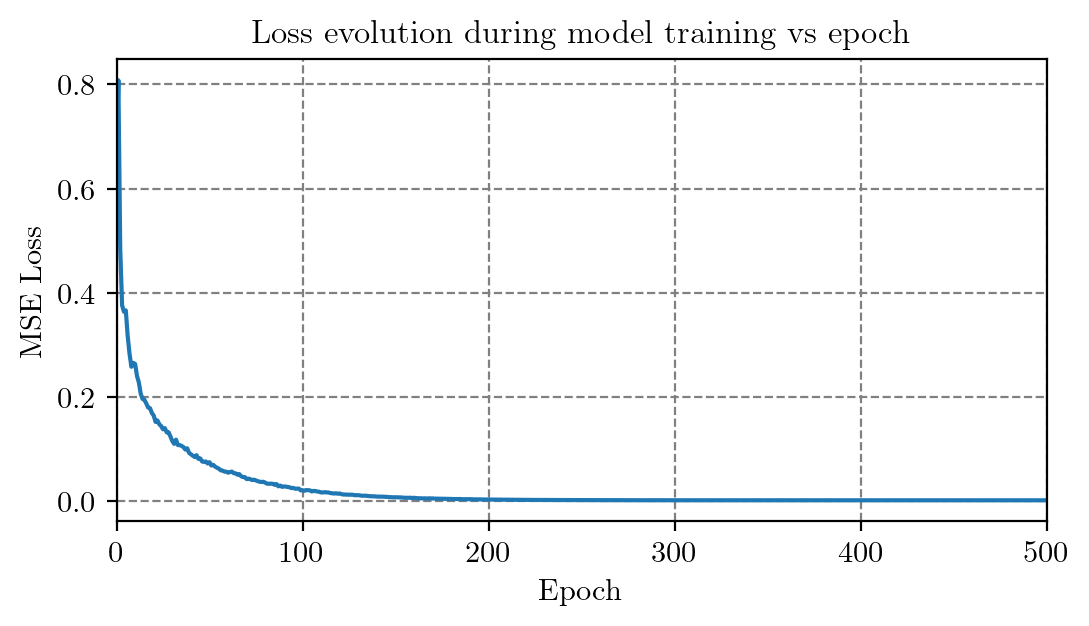

In [32]:
import time

# Set manual seed
torch.manual_seed(33)

layers = [200, 400, 400, 200]

input_size = X.size(1)
output_size = y.size(1)

# Define loss function (criterion)
criterion = nn.MSELoss()

# Initialize model from ann library
model = ann.FeatureForecaster(X.size(1), output_size, layers, p=0.4)

# Print model structure
model

# Get time-series sets for every continuous variable feature 
# (constant features by definition do not need to be forecasted)
model_filename = 'FeatureForecaster.pt'

# Check if tensors pt file is available in the data folder
filepath = os.path.join(cwd,'models','ann', model_filename)

# Import model settings if exists
if os.path.exists(filepath):
    model.load_state_dict(torch.load(filepath))

    # Set dropout and batch normalization layers to evaluation mode before 
    # running inference.
    model.eval()

    print(f'Model parameters imported successfully from:\n{filepath}')
else:

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.1) 

    start_time = time.time()

    epochs = 500
    losses = np.ones(epochs)*np.inf
    lr = np.zeros(epochs)

    # Iterate over all remaining features to get the time series subsets
    pb_epochs = utils.progressbar(range(epochs), 
                description='Training model ...', 
                desc_loc='right')

    for e in pb_epochs.iterations:

        # Get current learning rate
        lr[e] = rnn.get_lr(optimizer)
        model.train()
        
        # Predict values using the model
        y_pred = model(X_train)

        # Compute loss using the criterion
        loss = criterion(y_pred, y_train)

        # Add computed loss to the losses array for analysis
        losses[e] = loss.detach().numpy()

        # Update progress bar
        description = f'\n> Training model ...| LR = {lr[e]:1.2e} | MSE = {losses[e]:10.8f} | RMSE = {np.sqrt(losses[e]):10.8f}'
        pb_epochs.refresh(e+1, description = description)

        optimizer.zero_grad()

        # Backpropagate the loss
        loss.backward()

        # Adjust learning rate
        scheduler.step(loss)

        # Adjust parameters of the optimizer 
        optimizer.step()

    print(f'\nFinal MSE loss: {losses[-1]:10.8f}'
          f'\nTraning duration: {time.time() - start_time:.0f} seconds.')

    # Save the model trained parameters (weights and biases)
    print('Saving model parameters...', end='\r')
    # torch.save(model.state_dict(), filepath)
    print('Saving model parameters... Done.\n')

    # Plot loss evolution during training
    plt.figure(figsize=(6,3))
    plt.title(r'Loss evolution during model training vs epoch', fontsize=12)
    plt.plot(range(epochs), losses)
    plt.xlim(0, epochs)
    plt.ylabel('MSE Loss')
    plt.xlabel('Epoch')
    plt.grid(True, linestyle='--', c='grey')
    plt.show()

In [33]:
# Model validation
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    train_rmse = np.sqrt(criterion(y_pred, y_train))
    y_pred = model(X_test)
    test_rmse = np.sqrt(criterion(y_pred, y_test))
    
print(f'Model validation results:'
      f'\n - Train: MSE {train_rmse**2:10.4f} RMSE {train_rmse:10.4f}'
      f'\n - Test:  MSE {test_rmse**2:10.4f} RMSE {test_rmse:10.4f}')

Model validation results:
 - Train: MSE     0.0010 RMSE     0.0310
 - Test:  MSE     0.0010 RMSE     0.0315


In [35]:
example = 160
batch_size = 30

with torch.no_grad():
    y_pred = model(X_test[example:example+batch_size])
y_true = y_test[example:example+batch_size]

print(f'{feature:^34s}  | {"time_to_tca":^34s}')
print(f'{"Actual":^10s}  {"Forecast":^10s}  {"Error":>11s} | '
      f'{"Actual":^10s}  {"Forecast":^10s}  {"Error":>11s}')
for i, values in enumerate(y_pred):
    print(f'{y_true[i][0]:^10.4f}  {y_pred[i][0]:^10.4f}  {np.abs((y_true[i][0] - y_pred[i][0])/y_true[i][0])*100:>10.2f}% | '
          f'{y_true[i][1]:^10.4f}  {y_pred[i][1]:^10.4f}  {np.abs((y_true[i][1] - y_pred[i][1])/y_true[i][1])*100:>10.2f}%')



             Velocity               |            Time to TCA            
  Actual     Forecast         Error |   Actual     Forecast         Error
  0.0269      0.0190         29.39% |   0.0659      0.0487         26.13%
  0.0806      0.0809          0.39% |   0.0367      0.0490         33.65%
 -0.2375     -0.2189          7.84% |   0.0483      0.0492          1.87%
 -0.0144     -0.0104         27.78% |   0.0652      0.0480         26.47%
  0.2392      0.2399          0.31% |   0.0495      0.0516          4.40%
  0.0941      0.0926          1.65% |   0.0585      0.0481         17.72%
 -0.1056     -0.0317         69.98% |   0.0978      0.0923          5.64%
  0.0343      0.0287         16.18% |   0.0511      0.0480          6.12%
 -0.0635      0.1248        296.67% |   0.0422      0.0536         26.97%
 -0.0744     -0.0722          2.92% |   0.0488      0.0525          7.65%
 -0.0613     -0.0536         12.55% |   0.0386      0.0499         29.03%
  0.0449      0.0351         21.90% |  